In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns 
# set the plotting style 
sns.set_style("whitegrid")

# plot tree model
import graphviz

# Plot missing values
import missingno as msno

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Models
from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

# Imputation
from sklearn.impute import KNNImputer
#from fancyimpute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


# Data Processing

## Food Security Data

In [3]:
food_security = pd.read_csv('/content/MyDrive/MyDrive/FAOSTAT_data.csv')

In [4]:
food_security.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Suite of Food Security Indicators,4,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2012,2012,I$,2075.5,X,Figure from international organizations,NaN
1,FS,Suite of Food Security Indicators,4,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2013,2013,I$,2116.5,X,Figure from international organizations,NaN
2,FS,Suite of Food Security Indicators,4,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2014,2014,I$,2102.4,X,Figure from international organizations,NaN
3,FS,Suite of Food Security Indicators,4,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2015,2015,I$,2068.3,X,Figure from international organizations,NaN
4,FS,Suite of Food Security Indicators,4,Afghanistan,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2016,2016,I$,2057.1,X,Figure from international organizations,NaN


In [5]:
food_security.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46382 entries, 0 to 46381
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Domain Code       46382 non-null  object
 1   Domain            46382 non-null  object
 2   Area Code (M49)   46382 non-null  int64 
 3   Area              46382 non-null  object
 4   Element Code      46382 non-null  int64 
 5   Element           46382 non-null  object
 6   Item Code         46382 non-null  object
 7   Item              46382 non-null  object
 8   Year Code         46382 non-null  int64 
 9   Year              46382 non-null  object
 10  Unit              46382 non-null  object
 11  Value             35201 non-null  object
 12  Flag              46382 non-null  object
 13  Flag Description  46382 non-null  object
 14  Note              813 non-null    object
dtypes: int64(3), object(12)
memory usage: 5.3+ MB


In [6]:
food_security['Item'].unique()

array(['Gross domestic product per capita, PPP, (constant 2017 international $)',
       'Prevalence of undernourishment (percent) ',
       'Number of people undernourished (million) ',
       'Prevalence of moderate or severe food insecurity in the total population (percent) ',
       'Prevalence of moderate or severe food insecurity in the male adult population (percent) ',
       'Prevalence of moderate or severe food insecurity in the female adult population (percent) ',
       'Number of severely food insecure people (million) ',
       'Number of severely food insecure male adults (million) ',
       'Number of severely food insecure female adults (million) ',
       'Number of moderately or severely food insecure people (million) ',
       'Number of moderately or severely food insecure male adults (million) ',
       'Number of moderately or severely food insecure female adults (million) ',
       'Cereal import dependency ratio (percent) ',
       'Percent of arable land equi

### Converting data from long format to wide format

Gross domestic product per capita, PPP, (constant 2017 international $)

In [7]:
df = food_security[['Area', 'Year', 'Value']].loc[(food_security['Item'] == 'Gross domestic product per capita, PPP, (constant 2017 international $)' )]
df.rename(columns = {'Value': 'GDP'}, inplace = True)
df = df.reset_index(drop = True)
df = df.astype({'Year': int})
df.head()

,Area,Year,GDP
0,Afghanistan,2012,2075.5
1,Afghanistan,2013,2116.5
2,Afghanistan,2014,2102.4
3,Afghanistan,2015,2068.3
4,Afghanistan,2016,2057.1


Prevalence of undernourishment (percent) 

In [8]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Prevalence of undernourishment (percent) ' )]
temp.rename(columns = {'Value': 'undernourish%'}, inplace = True)
temp = temp.reset_index(drop = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%
0,Afghanistan,2012,2075.5,21.1
1,Afghanistan,2013,2116.5,20.7
2,Afghanistan,2014,2102.4,20.7
3,Afghanistan,2015,2068.3,21.5
4,Afghanistan,2016,2057.1,22.2


Number of people undernourished (million) 

In [9]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Number of people undernourished (million) ' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 'undernourish(in m)'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m)
0,Afghanistan,2012,2075.5,21.1,6.6
1,Afghanistan,2013,2116.5,20.7,6.7
2,Afghanistan,2014,2102.4,20.7,6.9
3,Afghanistan,2015,2068.3,21.5,7.4
4,Afghanistan,2016,2057.1,22.2,7.8


Prevalence of moderate or severe food insecurity in the total population (percent) 

In [10]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Prevalence of moderate or severe food insecurity in the total population (percent) ' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 'm/s_finsec%'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%
0,Afghanistan,2015,2068.3,21.5,7.4,45.1
1,Afghanistan,2016,2057.1,22.2,7.8,49.6
2,Afghanistan,2017,2058.4,23,8.3,54.3
3,Afghanistan,2018,2033.8,24,8.9,57.5
4,Afghanistan,2019,2065,26.9,10.2,63.1


Number of severely food insecure people (million) 

In [11]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Number of severely food insecure people (million) ' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 's_finsec(in m)'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m)
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1
1,Afghanistan,2016,2057.1,22.2,7.8,49.6,5.3
2,Afghanistan,2017,2058.4,23,8.3,54.3,6.3
3,Afghanistan,2018,2033.8,24,8.9,57.5,6.4
4,Afghanistan,2019,2065,26.9,10.2,63.1,7.5


Number of moderately or severely food insecure people (million) 

In [12]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Number of moderately or severely food insecure people (million) ' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 'm/s_finsec(in m)'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m)
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5
1,Afghanistan,2016,2057.1,22.2,7.8,49.6,5.3,17.6
2,Afghanistan,2017,2058.4,23,8.3,54.3,6.3,19.7
3,Afghanistan,2018,2033.8,24,8.9,57.5,6.4,21.4
4,Afghanistan,2019,2065,26.9,10.2,63.1,7.5,24


Per capita food production variability (constant 2014-2016 thousand int$ per capita)

In [13]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Per capita food production variability (constant 2014-2016 thousand int$ per capita)' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 'pcap_fprod'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2
1,Afghanistan,2016,2057.1,22.2,7.8,49.6,5.3,17.6,6.2
2,Afghanistan,2017,2058.4,23,8.3,54.3,6.3,19.7,6.9
3,Afghanistan,2018,2033.8,24,8.9,57.5,6.4,21.4,6.8
4,Afghanistan,2019,2065,26.9,10.2,63.1,7.5,24,5.7


Per capita food supply variability (kcal/cap/day)

In [14]:
temp = food_security[['Area', 'Year Code', 'Value']].loc[(food_security['Item'] == 'Per capita food supply variability (kcal/cap/day)' )]
temp = temp.reset_index(drop = True)
temp.rename(columns = {'Value': 'pcap_fsup'}, inplace = True)
temp = temp.astype({'Year Code': 'string'})
temp['Year'] = temp['Year Code'].str[0:4] 
temp = temp.astype({'Year': int})
temp.drop(['Year Code'], axis = 1, inplace = True)
temp['Year'] = temp['Year']+1

df = pd.merge(df, temp, on = ['Area', 'Year'])
df.head()

,Area,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38
1,Afghanistan,2016,2057.1,22.2,7.8,49.6,5.3,17.6,6.2,33
2,Afghanistan,2017,2058.4,23,8.3,54.3,6.3,19.7,6.9,20
3,Afghanistan,2018,2033.8,24,8.9,57.5,6.4,21.4,6.8,27
4,Afghanistan,2019,2065,26.9,10.2,63.1,7.5,24,5.7,29


## Disasters Data

In [15]:
disasters = pd.read_csv('/content/MyDrive/MyDrive/emdat.csv', encoding = 'latin-1')
disasters.head()

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1999-0301-CHN,1999,301,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Wendy,...,NaN,NaN,NaN,277900.0,452063.0,61.473667,NaN,NaN,NaN,NaN
1,1999-0277-BGD,1999,277,NaN,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61.473667,NaN,NaN,NaN,NaN
2,1999-0104-AUS,1999,104,NaN,Natural,Meteorological,Storm,Convective storm,Hail,NaN,...,NaN,1100000.0,1789384.0,1500000.0,2440069.0,61.473667,NaN,NaN,NaN,NaN
3,1999-0736-BGD,1999,736,NaN,Natural,Hydrological,Flood,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61.473667,NaN,NaN,NaN,NaN
4,1999-0051-AUS,1999,51,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Rona,...,NaN,NaN,NaN,300000.0,488014.0,61.473667,NaN,NaN,NaN,NaN


In [16]:
disasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15625 entries, 0 to 15624
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Dis No                                     15625 non-null  object 
 1   Year                                       15625 non-null  int64  
 2   Seq                                        15625 non-null  int64  
 3   Glide                                      1731 non-null   object 
 4   Disaster Group                             15625 non-null  object 
 5   Disaster Subgroup                          15625 non-null  object 
 6   Disaster Type                              15625 non-null  object 
 7   Disaster Subtype                           14051 non-null  object 
 8   Disaster Subsubtype                        768 non-null    object 
 9   Event Name                                 4946 non-null   object 
 10  Country               

In [17]:
disasters = disasters[["Year","Country","Region","Continent","Disaster Group", "Disaster Subgroup","Disaster Type","Dis Mag Value","Dis Mag Scale", "CPI"]]

In [18]:
disasters.rename(columns = {'Country':'Cty',
                            'Region': 'Reg',
                            'Continent':'Con', 
                            'Disaster Group' : 'DisGrp',
                            'Disaster Subgroup':'DisSubgrp',
                            'Disaster Type': 'DisType',
                            'Dis Mag Value': 'Mag',
                            'Dis Mag Scale' : 'Scale'}, inplace = True)
disasters.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Year,Cty,Reg,Con,DisGrp,DisSubgrp,DisType,Mag,Scale,CPI
0,1999,China,Eastern Asia,Asia,Natural,Meteorological,Storm,NaN,Kph,61.473667
1,1999,Bangladesh,Southern Asia,Asia,Natural,Hydrological,Flood,NaN,Km2,61.473667
2,1999,Australia,Australia and New Zealand,Oceania,Natural,Meteorological,Storm,NaN,Kph,61.473667
3,1999,Bangladesh,Southern Asia,Asia,Natural,Hydrological,Flood,NaN,Km2,61.473667
4,1999,Australia,Australia and New Zealand,Oceania,Natural,Meteorological,Storm,170.0,Kph,61.473667


## Appending Datasets

In [19]:
df.rename(columns = {'Area':'Cty'}, inplace = True)
df = pd.merge(df, disasters, on = ['Cty', 'Year'])
df

,Cty,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup,Reg,Con,DisGrp,DisSubgrp,DisType,Mag,Scale,CPI
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38,Southern Asia,Asia,Natural,Hydrological,Landslide,NaN,NaN,87.469932
1,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38,Southern Asia,Asia,Natural,Hydrological,Landslide,NaN,NaN,87.469932
2,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38,Southern Asia,Asia,Natural,Geophysical,Earthquake,8.0,Richter,87.469932
3,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38,Southern Asia,Asia,Natural,Geophysical,Earthquake,6.0,Richter,87.469932
4,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38,Southern Asia,Asia,Natural,Hydrological,Flood,NaN,Km2,87.469932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,Zimbabwe,2018,3923,NaN,NaN,66.7,4.9,9.6,6.4,28,Eastern Africa,Africa,Technological,Technological,Transport accident,NaN,NaN,92.669670
2527,Zimbabwe,2018,3923,NaN,NaN,66.7,4.9,9.6,6.4,28,Eastern Africa,Africa,Technological,Technological,Transport accident,NaN,NaN,92.669670
2528,Zimbabwe,2019,3630,NaN,NaN,69.8,4.7,10.2,7.4,29,Eastern Africa,Africa,Natural,Meteorological,Storm,NaN,Kph,94.349092
2529,Zimbabwe,2019,3630,NaN,NaN,69.8,4.7,10.2,7.4,29,Eastern Africa,Africa,Natural,Hydrological,Flood,154678.0,Km2,94.349092


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 2530
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cty                 2531 non-null   object 
 1   Year                2531 non-null   int64  
 2   GDP                 2531 non-null   object 
 3   undernourish%       2343 non-null   object 
 4   undernourish(in m)  1722 non-null   object 
 5   m/s_finsec%         1707 non-null   object 
 6   s_finsec(in m)      1707 non-null   object 
 7   m/s_finsec(in m)    1707 non-null   object 
 8   pcap_fprod          2529 non-null   object 
 9   pcap_fsup           2503 non-null   object 
 10  Reg                 2531 non-null   object 
 11  Con                 2531 non-null   object 
 12  DisGrp              2531 non-null   object 
 13  DisSubgrp           2531 non-null   object 
 14  DisType             2531 non-null   object 
 15  Mag                 493 non-null    float64
 16  Scale 

In [21]:
df = df.astype({'GDP': float})
df['undernourish%'] = pd.to_numeric(df['undernourish%'], errors='coerce')
df['undernourish(in m)'] = pd.to_numeric(df['undernourish(in m)'], errors='coerce')
df['m/s_finsec%'] = pd.to_numeric(df['m/s_finsec%'], errors='coerce')
df['s_finsec(in m)'] = pd.to_numeric(df['s_finsec(in m)'], errors='coerce')
df['m/s_finsec(in m)'] = pd.to_numeric(df['m/s_finsec(in m)'], errors='coerce')
df['pcap_fprod'] = pd.to_numeric(df['pcap_fprod'], errors='coerce')
df['pcap_fsup'] = pd.to_numeric(df['pcap_fsup'], errors='coerce')
df['Mag'] = pd.to_numeric(df['Mag'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 0 to 2530
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cty                 2531 non-null   object 
 1   Year                2531 non-null   int64  
 2   GDP                 2531 non-null   float64
 3   undernourish%       1722 non-null   float64
 4   undernourish(in m)  1680 non-null   float64
 5   m/s_finsec%         1707 non-null   float64
 6   s_finsec(in m)      1621 non-null   float64
 7   m/s_finsec(in m)    1690 non-null   float64
 8   pcap_fprod          2529 non-null   float64
 9   pcap_fsup           2503 non-null   float64
 10  Reg                 2531 non-null   object 
 11  Con                 2531 non-null   object 
 12  DisGrp              2531 non-null   object 
 13  DisSubgrp           2531 non-null   object 
 14  DisType             2531 non-null   object 
 15  Mag                 493 non-null    float64
 16  Scale 

In [22]:
df.head()

,Cty,Year,GDP,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup,Reg,Con,DisGrp,DisSubgrp,DisType,Mag,Scale,CPI
0,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38.0,Southern Asia,Asia,Natural,Hydrological,Landslide,NaN,NaN,87.469932
1,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38.0,Southern Asia,Asia,Natural,Hydrological,Landslide,NaN,NaN,87.469932
2,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38.0,Southern Asia,Asia,Natural,Geophysical,Earthquake,8.0,Richter,87.469932
3,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38.0,Southern Asia,Asia,Natural,Geophysical,Earthquake,6.0,Richter,87.469932
4,Afghanistan,2015,2068.3,21.5,7.4,45.1,5.1,15.5,8.2,38.0,Southern Asia,Asia,Natural,Hydrological,Flood,NaN,Km2,87.469932


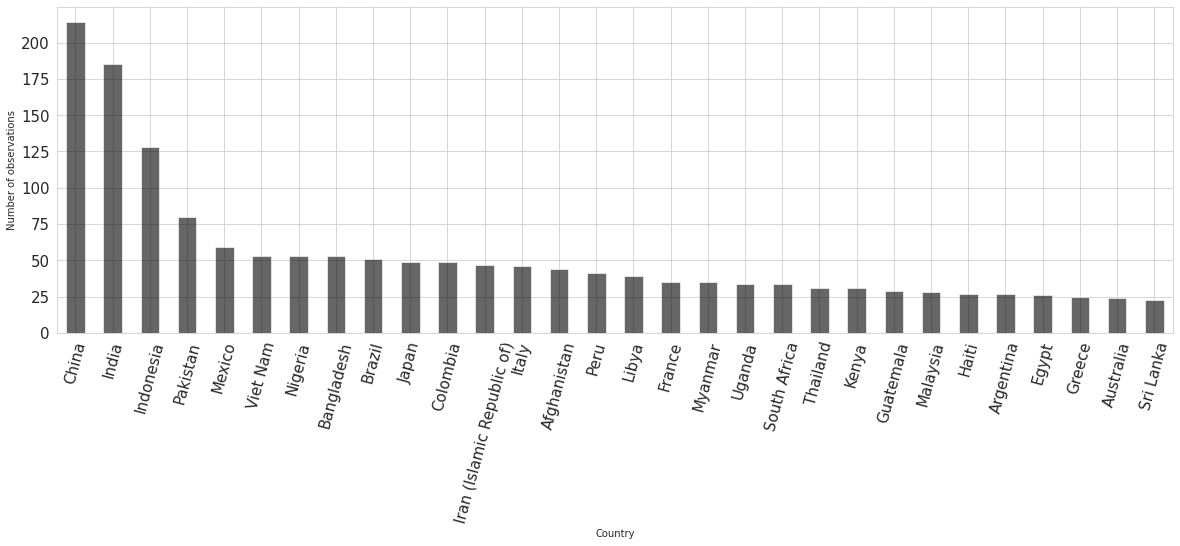

In [23]:
df['Cty'].value_counts().head(30).plot(kind = 'bar', figsize = (20,6), color = 'k', alpha = 0.6)

plt.xlabel("Country", fontsize = 10)
plt.ylabel("Number of observations", fontsize = 10)

plt.xticks(rotation = 75)
plt.tick_params(labelsize = 15)

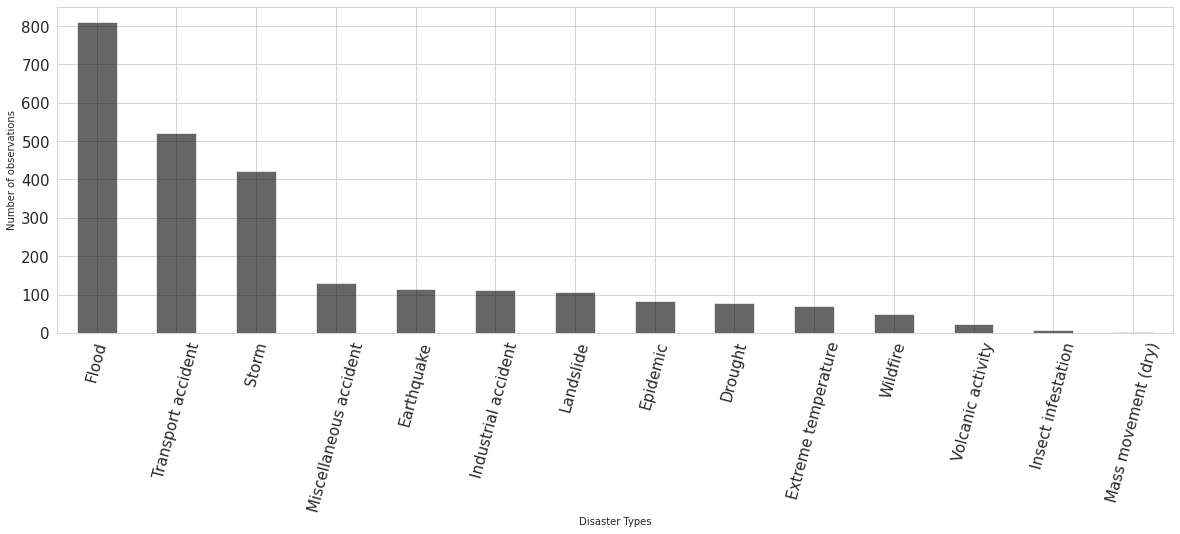

In [24]:
df['DisType'].value_counts().head(30).plot(kind = 'bar', figsize = (20,6), color = 'k', alpha = 0.6)

plt.xlabel("Disaster Types", fontsize = 10)
plt.ylabel("Number of observations", fontsize = 10)

plt.xticks(rotation = 75)
plt.tick_params(labelsize = 15)

# Data Cleaning

In [25]:
df.isna().sum()

Cty                      0
Year                     0
GDP                      0
undernourish%          809
undernourish(in m)     851
m/s_finsec%            824
s_finsec(in m)         910
m/s_finsec(in m)       841
pcap_fprod               2
pcap_fsup               28
Reg                      0
Con                      0
DisGrp                   0
DisSubgrp                0
DisType                  0
Mag                   2038
Scale                  791
CPI                      0
dtype: int64

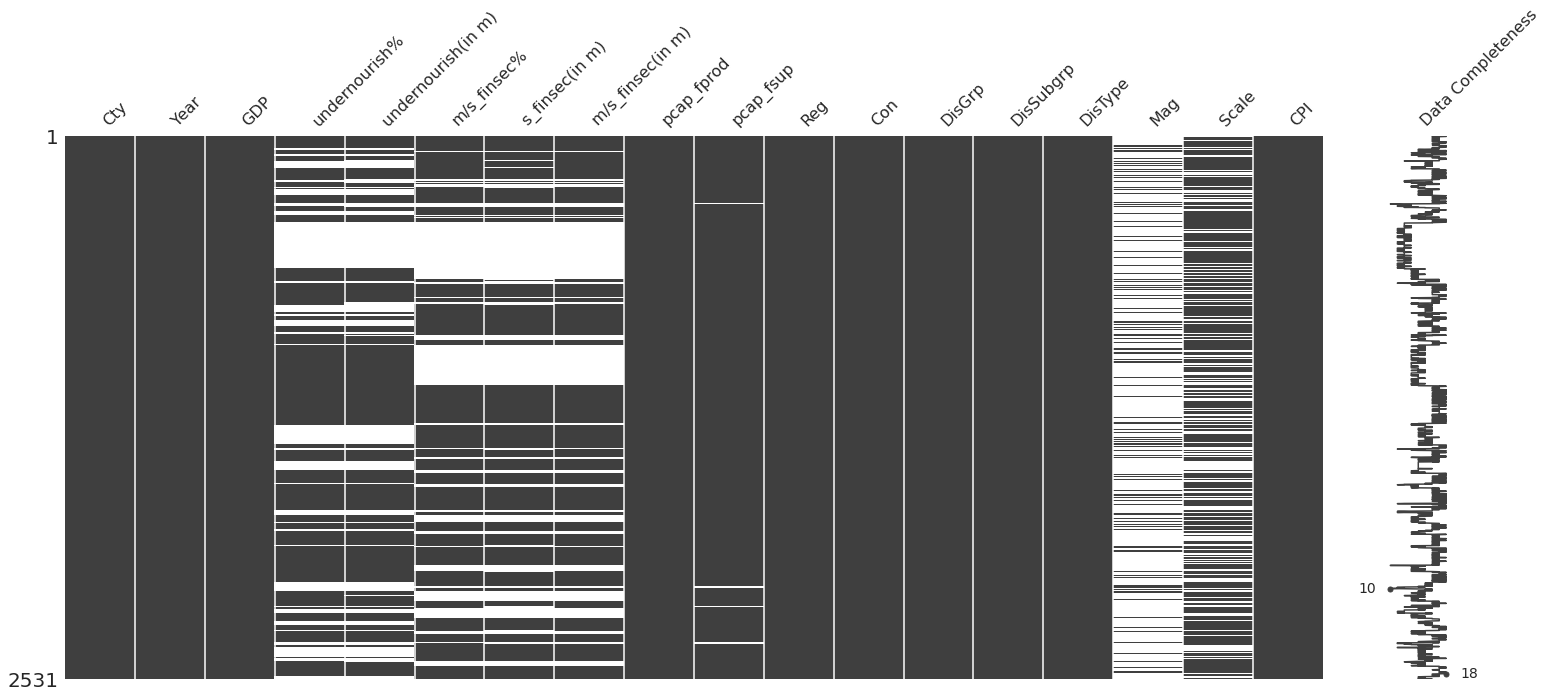

In [26]:
msno.matrix(df, labels = True);

Number of disasters in each type

In [27]:
df['DisType'].value_counts()

Flood                     810
Transport accident        522
Storm                     423
Miscellaneous accident    131
Earthquake                114
Industrial accident       113
Landslide                 106
Epidemic                   84
Drought                    77
Extreme temperature        71
Wildfire                   48
Volcanic activity          22
Insect infestation          7
Mass movement (dry)         3
Name: DisType, dtype: int64

Number of disasters having magnitude values

In [28]:
df[['DisType','Mag']].groupby('DisType').count()

,Mag
DisType,
Drought,0
Earthquake,113
Epidemic,4
Extreme temperature,37
Flood,208
Industrial accident,1
Insect infestation,0
Landslide,2
Mass movement (dry),0


Imputation using Mice imputation for each type of disasters and also normalizing the magnitude

Flood

In [29]:
df1 = pd.DataFrame()
df2 = df.loc[df['DisType'] == 'Flood']

df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Flood'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

Earthquake

In [30]:
df2 = df.loc[df['DisType'] == 'Earthquake']

df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Earthquake'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index=True)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Storm

In [31]:
df2 = df.loc[df['DisType'] == 'Storm']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Storm'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Extreme Temperature

In [32]:
df2 = df.loc[df['DisType'] == 'Extreme temperature']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Extreme temperature'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Wildfire

In [33]:
df2 = df.loc[df['DisType'] == 'Wildfire']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Wildfire'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

Epidemic

In [34]:
df2 = df.loc[df['DisType'] == 'Epidemic']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Epidemic'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

Landslide

In [35]:
df2 = df.loc[df['DisType'] == 'Landslide']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Landslide'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed, ignore_index = True)

Industrial Accident

In [36]:
df2 = df.loc[df['DisType'] == 'Industrial accident']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Industrial accident'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed,ignore_index = True)

Volcanic Activity

In [37]:
df2 = df.loc[df['DisType'] == 'Volcanic activity']
df_mice = df2.filter(['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','Mag','CPI'], axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed['DisType'] = 'Volcanic activity'

values = df_mice_imputed['Mag'].values.astype(float).reshape(-1,1)
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(values)
df_mice_imputed['normalized']=scaled_values

df1 = df1.append(df_mice_imputed,ignore_index = True)
df1

,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup,Mag,CPI,DisType,normalized
0,21.5,7.400000,45.100000,5.100000,15.500000,8.2,38.0,136547.077278,87.469932,Flood,0.055917
1,22.2,7.800000,49.600000,5.300000,17.600000,6.2,33.0,136547.103195,88.573453,Flood,0.055917
2,22.2,7.800000,49.600000,5.300000,17.600000,6.2,33.0,136547.103195,88.573453,Flood,0.055917
3,22.2,7.800000,49.600000,5.300000,17.600000,6.2,33.0,136547.103195,88.573453,Flood,0.055917
4,22.2,7.800000,49.600000,5.300000,17.600000,6.2,33.0,136547.103195,88.573453,Flood,0.055917
...,...,...,...,...,...,...,...,...,...,...,...
1786,21.9,1.900000,54.018744,2.700876,6.591728,1.6,14.0,5.000000,94.349092,Volcanic activity,0.000000
1787,8.1,2.600000,47.800000,6.200000,15.500000,12.6,26.0,5.000000,94.349092,Volcanic activity,0.000000
1788,12.3,3.956011,25.933263,1.860309,8.503045,31.8,32.0,5.000000,90.460179,Volcanic activity,0.000000
1789,12.6,6.404369,23.300000,1.763930,9.143962,34.6,48.0,5.000000,92.669670,Volcanic activity,0.000000


Saving as a CSV file in drive

In [38]:
df1.to_csv('/content/MyDrive/MyDrive/final_normalized_data.csv', encoding = 'utf-8', index = False)

In [39]:
df1.isna().sum()

undernourish%         0
undernourish(in m)    0
m/s_finsec%           0
s_finsec(in m)        0
m/s_finsec(in m)      0
pcap_fprod            0
pcap_fsup             0
Mag                   0
CPI                   0
DisType               0
normalized            0
dtype: int64

In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1791 entries, 0 to 1790
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   undernourish%       1791 non-null   float64
 1   undernourish(in m)  1791 non-null   float64
 2   m/s_finsec%         1791 non-null   float64
 3   s_finsec(in m)      1791 non-null   float64
 4   m/s_finsec(in m)    1791 non-null   float64
 5   pcap_fprod          1791 non-null   float64
 6   pcap_fsup           1791 non-null   float64
 7   Mag                 1791 non-null   float64
 8   CPI                 1791 non-null   float64
 9   DisType             1791 non-null   object 
 10  normalized          1791 non-null   float64
dtypes: float64(10), object(1)
memory usage: 154.0+ KB


Normalizing remaining columns

In [41]:
cols_to_norm = ['undernourish%','undernourish(in m)','m/s_finsec%','s_finsec(in m)','m/s_finsec(in m)','pcap_fprod','pcap_fsup','CPI']
x = df1[cols_to_norm]
 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled, columns = ['undernourish%','undernourish(in m)','m/s_finsec%','s_finsec(in m)','m/s_finsec(in m)','pcap_fprod','pcap_fsup','CPI'] )
df2['magnitude'] = df1['normalized']
df2['DisType'] = df1['DisType']
df2

,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup,CPI,magnitude,DisType
0,0.542537,0.182562,0.791732,0.240529,0.148919,0.044318,0.235714,0.000000,0.055917,Flood
1,0.553813,0.184069,0.803832,0.244958,0.159559,0.032955,0.200000,0.137202,0.055917,Flood
2,0.553813,0.184069,0.803832,0.244958,0.159559,0.032955,0.200000,0.137202,0.055917,Flood
3,0.553813,0.184069,0.803832,0.244958,0.159559,0.032955,0.200000,0.137202,0.055917,Flood
4,0.553813,0.184069,0.803832,0.244958,0.159559,0.032955,0.200000,0.137202,0.055917,Flood
...,...,...,...,...,...,...,...,...,...,...
1786,0.548980,0.161833,0.815715,0.187408,0.103782,0.006818,0.064286,0.855294,0.000000,Volcanic activity
1787,0.326692,0.164472,0.798992,0.264885,0.148919,0.069318,0.150000,0.855294,0.000000,Volcanic activity
1788,0.394345,0.169582,0.740191,0.168796,0.113466,0.178409,0.192857,0.371781,0.000000,Volcanic activity
1789,0.399177,0.178809,0.733110,0.166662,0.116714,0.194318,0.307143,0.646489,0.000000,Volcanic activity


# EDA

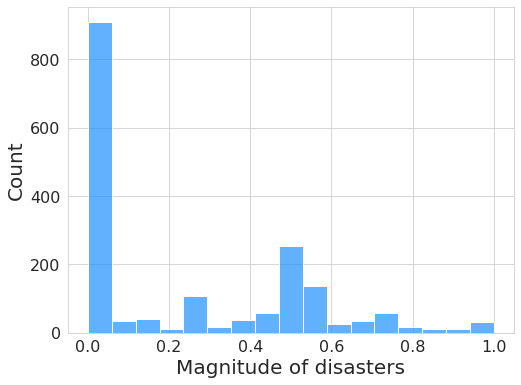

In [42]:
plt.figure(figsize = (8,6))

sns.histplot(data = df2, x = 'magnitude', bins = 17 , color = 'dodgerblue', alpha = 0.7)

plt.ylabel('Count',fontsize = 20)
plt.xlabel('Magnitude of disasters', fontsize = 20)

plt.tick_params(labelsize = 16 )

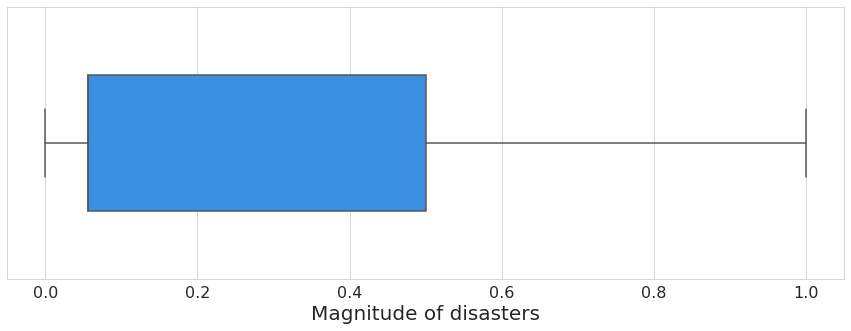

In [43]:
plt.figure(figsize = (15,5))

sns.boxplot(data = df2, x = 'magnitude', color = 'dodgerblue', width = 0.5)

plt.xlabel('Magnitude of disasters', fontsize = 20)

plt.tick_params(labelsize = 16 )

In [44]:
df2.describe()

,undernourish%,undernourish(in m),m/s_finsec%,s_finsec(in m),m/s_finsec(in m),pcap_fprod,pcap_fsup,CPI,magnitude
count,1791.000000,1791.000000,1791.000000,1791.000000,1791.000000,1791.000000,1791.000000,1791.000000,1791.000000
mean,0.380445,0.249107,0.718792,0.229738,0.178723,0.091670,0.188331,0.514533,0.263944
std,0.136272,0.173868,0.128965,0.124998,0.148027,0.108463,0.146781,0.370613,0.267349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.291255,0.162964,0.689279,0.147533,0.093690,0.027273,0.085714,0.137202,0.055917
50%,0.358541,0.185478,0.730327,0.202888,0.139637,0.053409,0.150000,0.646489,0.055917
75%,0.422261,0.256508,0.780707,0.262344,0.208162,0.113068,0.242857,0.855294,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


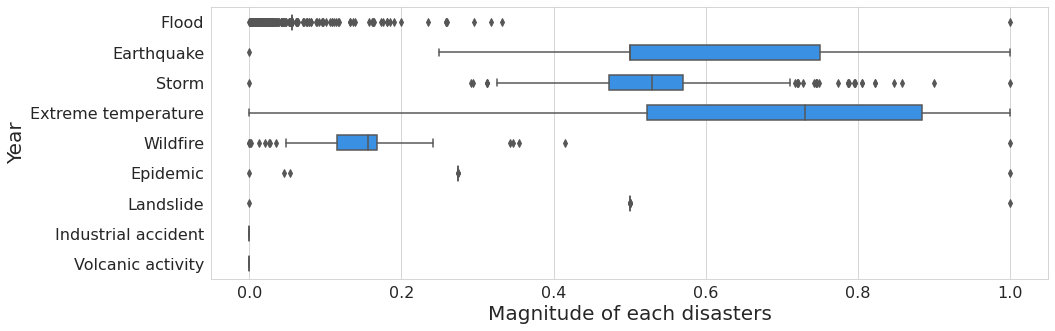

In [45]:
plt.figure(figsize = (15,5))
sns.boxplot(data = df2, x = 'magnitude', y = 'DisType', color = 'dodgerblue', width = 0.5, orient = 'h')
plt.ylabel('Year',fontsize = 20)
plt.xlabel('Magnitude of each disasters', fontsize = 20)

plt.tick_params(labelsize = 16)

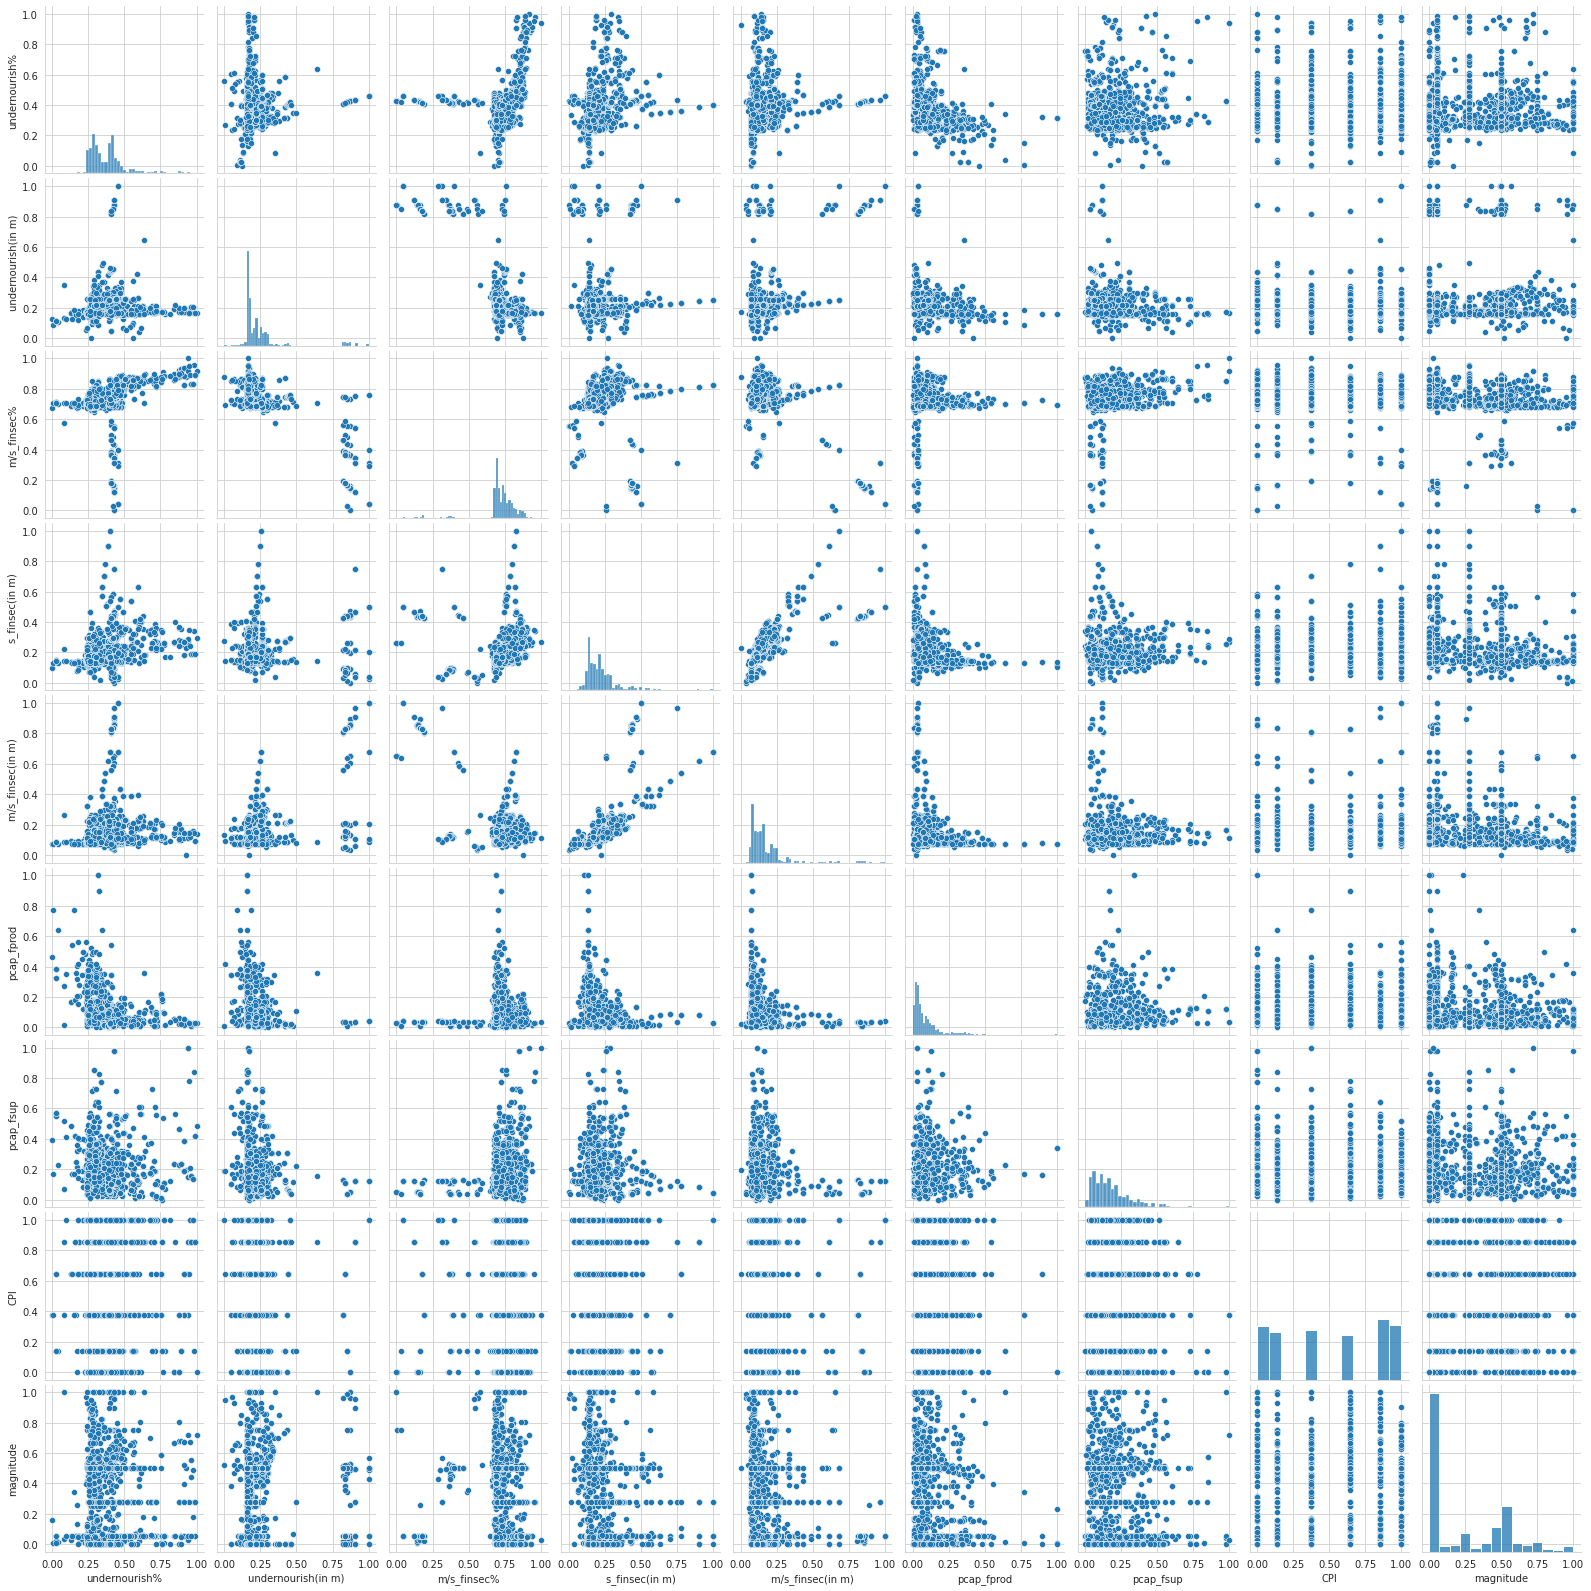

In [46]:
sns.pairplot(df2)

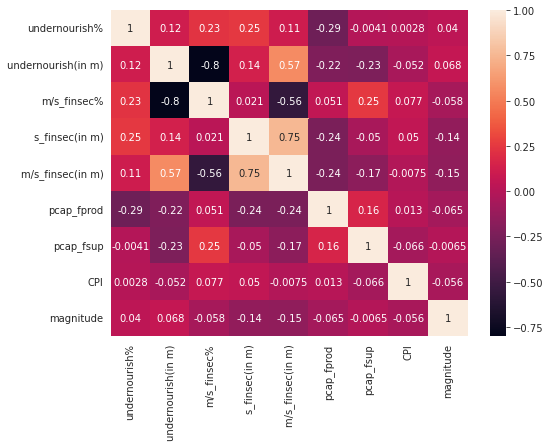

In [47]:
plt.figure(figsize = (8,6))
sns.heatmap(df2.corr(),annot=True)

From the pairplot and heatmap we can see there is more non-linearity in the data

# Modelling

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1791 entries, 0 to 1790
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   undernourish%       1791 non-null   float64
 1   undernourish(in m)  1791 non-null   float64
 2   m/s_finsec%         1791 non-null   float64
 3   s_finsec(in m)      1791 non-null   float64
 4   m/s_finsec(in m)    1791 non-null   float64
 5   pcap_fprod          1791 non-null   float64
 6   pcap_fsup           1791 non-null   float64
 7   CPI                 1791 non-null   float64
 8   magnitude           1791 non-null   float64
 9   DisType             1791 non-null   object 
dtypes: float64(9), object(1)
memory usage: 140.0+ KB


In [49]:
X = df2[['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','CPI']]
y = df2['magnitude']

In [50]:
X.shape, y.shape

((1791, 8), (1791,))

### CNN

In [51]:
X = np.array(X).reshape(x.shape[0], x.shape[1], 1)
y = np.array(y).reshape(-1,1)
X.shape, y.shape

((1791, 8, 1), (1791, 1))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1432, 8, 1), (359, 8, 1), (1432, 1), (359, 1))

In [53]:
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(8, 1)))
model.add(Flatten())
model.add(Dense(64, activation="linear"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             96        
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 64)                14400     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,561
Trainable params: 14,561
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(X_train, y_train, batch_size=12,epochs=200, verbose=0)

In [55]:
y_pred = model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [56]:
print(model.evaluate(X_train, y_train))

45/45 [==============================] - 0s 2ms/step - loss: 0.0553
0.055250078439712524


In [57]:
mean_squared_error(y_test, y_pred)

0.058750684852543825

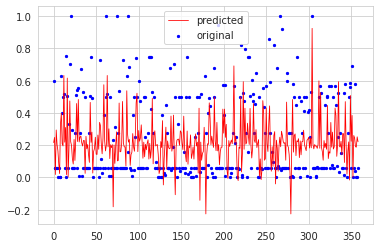

In [58]:
x_ax = range(len(y_pred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

### Linear Model

In [59]:
X = df2[['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','CPI']]
y = df2['magnitude']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [61]:
model_lr = linear_model.LinearRegression()

In [62]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred_lr = model_lr.predict(X_test)

In [64]:
mean_squared_error(y_test, y_pred_lr)

0.06471648857720909

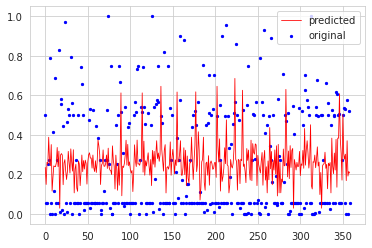

In [65]:
x_ax = range(len(y_pred_lr))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_lr, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
model_rf = RandomForestRegressor(100, min_samples_leaf=5)

In [68]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5)

In [69]:
y_pred_rf = model_rf.predict(X_test)

In [70]:
mean_squared_error(y_test, y_pred_rf)

0.046373441431054006

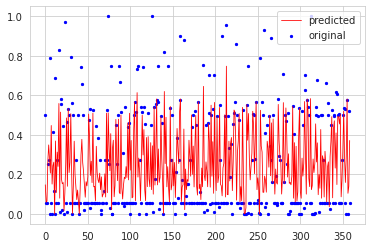

In [71]:
x_ax = range(len(y_pred_rf))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_rf, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

### Multiple linear regression

In [72]:
model_mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
y_pred_mlr = model_mlr.predict(sm.add_constant(X_test))

In [74]:
mean_squared_error(y_test, y_pred_mlr, squared = False).round(3)

0.254

In [75]:
mean_absolute_error(y_test, y_pred_mlr)

0.2199223749788984

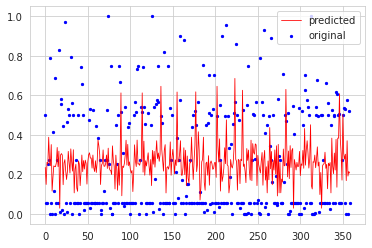

In [76]:
x_ax = range(len(y_pred_mlr))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_mlr, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## We can conclude that the CNN and RandomForest models best fitted the data

# Modeling on different disasters

In [77]:
df2['DisType'].value_counts()

Flood                  810
Storm                  423
Earthquake             114
Industrial accident    113
Landslide              106
Epidemic                84
Extreme temperature     71
Wildfire                48
Volcanic activity       22
Name: DisType, dtype: int64

## Flood Data

In [78]:
df3 = df2.loc[df2['DisType'] == 'Flood']
X = df3[['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','CPI']]
y = df3['magnitude']
X.shape, y.shape

((810, 8), (810,))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((648, 8), (162, 8), (648,), (162,))

##### CNN

In [80]:
modelf = Sequential()
modelf.add(Conv1D(32, 2, activation="relu", input_shape=(8, 1)))
modelf.add(Flatten())
modelf.add(Dense(64, activation="linear"))
modelf.add(Dense(1))
modelf.compile(loss="mse", optimizer="adam")
 
modelf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 32)             96        
                                                                 
 flatten_1 (Flatten)         (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                14400     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,561
Trainable params: 14,561
Non-trainable params: 0
_________________________________________________________________


In [81]:
modelf.fit(X_train, y_train, batch_size=12,epochs=200, verbose=0)

In [82]:
y_pred_flood = modelf.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [83]:
print(modelf.evaluate(X_train, y_train))

21/21 [==============================] - 0s 2ms/step - loss: 0.0018
0.001841248362325132


In [84]:
mean_squared_error(y_test, y_pred_flood)

0.0022465595359416495

##### Random Forest

In [85]:
model_rff = RandomForestRegressor(100, min_samples_leaf=5)
model_rff.fit(X_train, y_train)
y_pred_rf = model_rff.predict(X_test)
mean_squared_error(y_test, y_pred_rf)

0.001903700303875163

## Storm

In [86]:
df3 = df2.loc[df2['DisType'] == 'Storm']
X = df3[['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','CPI']]
y = df3['magnitude']
X.shape, y.shape

((423, 8), (423,))

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((338, 8), (85, 8), (338,), (85,))

##### CNN

In [88]:
models = Sequential()
models.add(Conv1D(32, 2, activation="relu", input_shape=(8, 1)))
models.add(Flatten())
models.add(Dense(64, activation="linear"))
models.add(Dense(1))
models.compile(loss="mse", optimizer="adam")
 
models.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 32)             96        
                                                                 
 flatten_2 (Flatten)         (None, 224)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                14400     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,561
Trainable params: 14,561
Non-trainable params: 0
_________________________________________________________________


In [89]:
models.fit(X_train, y_train, batch_size=12,epochs=200, verbose=0)

In [90]:
y_pred_storm = models.predict(X_test)

3/3 [==============================] - 0s 5ms/step


In [91]:
print(models.evaluate(X_train, y_train))

11/11 [==============================] - 0s 2ms/step - loss: 0.0011
0.001124782720580697


In [92]:
mean_squared_error(y_test, y_pred_storm)

0.0009683010437168782

##### Random Forest

In [93]:
model_rfs = RandomForestRegressor(100, min_samples_leaf=5)
model_rfs.fit(X_train, y_train)
y_pred_rf = model_rfs.predict(X_test)
mean_squared_error(y_test, y_pred_rf)

0.0025009515344230245

## Earthquake

In [94]:
df3 = df2.loc[df2['DisType'] == 'Earthquake']
X = df3[['undernourish%', 'undernourish(in m)', 'm/s_finsec%', 's_finsec(in m)', 'm/s_finsec(in m)', 'pcap_fprod', 'pcap_fsup','CPI']]
y = df3['magnitude']
X.shape, y.shape

((114, 8), (114,))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91, 8), (23, 8), (91,), (23,))

##### CNN

In [96]:
modele = Sequential()
modele.add(Conv1D(32, 2, activation="relu", input_shape=(8, 1)))
modele.add(Flatten())
modele.add(Dense(64, activation="linear"))
modele.add(Dense(1))
modele.compile(loss="mse", optimizer="adam")
 
modele.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 7, 32)             96        
                                                                 
 flatten_3 (Flatten)         (None, 224)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                14400     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,561
Trainable params: 14,561
Non-trainable params: 0
_________________________________________________________________


In [97]:
modele.fit(X_train, y_train, batch_size=12,epochs=200, verbose=0)

In [98]:
y_pred_eq = modele.predict(X_test)

1/1 [==============================] - 0s 64ms/step


In [99]:
print(modele.evaluate(X_train, y_train))

3/3 [==============================] - 0s 4ms/step - loss: 0.0403
0.0403049997985363


In [100]:
mean_squared_error(y_test, y_pred_eq)

0.05910966513014087

##### Random Forest

In [101]:
model_rfe = RandomForestRegressor(100, min_samples_leaf=5)
model_rfe.fit(X_train, y_train)
y_pred_rf = model_rfe.predict(X_test)
mean_squared_error(y_test, y_pred_rf)

0.034295621937359765

## We can conclude that Flood and Storm has much impact on Food insecurity compared to Earthquake.